In [1]:
# 📘 Step 1: Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [3]:
# 📘 Step 2: Load Dataset
# NOTE: Replace path below with your dataset path if different
df = pd.read_csv("uber.csv")

print("✅ Dataset Loaded Successfully")
print("Shape of dataset:", df.shape)
df.head()


✅ Dataset Loaded Successfully
Shape of dataset: (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
# 📘 Step 3: Check dataset info and missing values
df.info()
print("\nMissing values per column:\n")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB

Missing values per column:

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [7]:
# 📘 Step 4: Standardize column names
df.columns = [col.strip().lower() for col in df.columns]
df.head(3)


,unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


In [9]:
# 📘 Step 5: Check basic statistics
df.describe()


,unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [11]:
# 📘 Step 6: Extract datetime features (if available)
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['weekday'] = df['pickup_datetime'].dt.weekday
    print("✅ Datetime column processed.")
else:
    print("⚠️ pickup_datetime column not found.")


✅ Datetime column processed.


In [13]:
# 📘 Step 7: Compute distance from coordinates using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

if all(x in df.columns for x in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']):
    df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                  df['dropoff_latitude'], df['dropoff_longitude'])
    print("✅ Distance column (distance_km) added.")
else:
    print("⚠️ Latitude/Longitude columns not found.")


✅ Distance column (distance_km) added.


In [15]:
# 📘 Step 8: Remove invalid fares and outliers
before = df.shape[0]
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 500)]
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 200)]
print("Removed rows:", before - df.shape[0])
print("Remaining data:", df.shape)


Removed rows: 6092
Remaining data: (193908, 14)


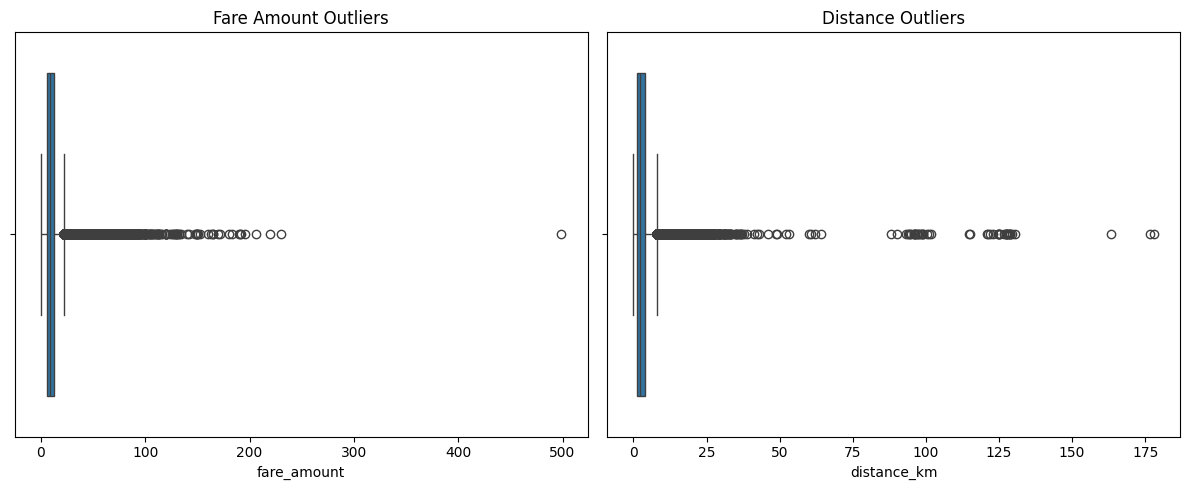

In [17]:
# 📘 Step 9: Identify Outliers using IQR
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=df['fare_amount'])
plt.title("Fare Amount Outliers")

plt.subplot(1,2,2)
sns.boxplot(x=df['distance_km'])
plt.title("Distance Outliers")
plt.tight_layout()
plt.show()


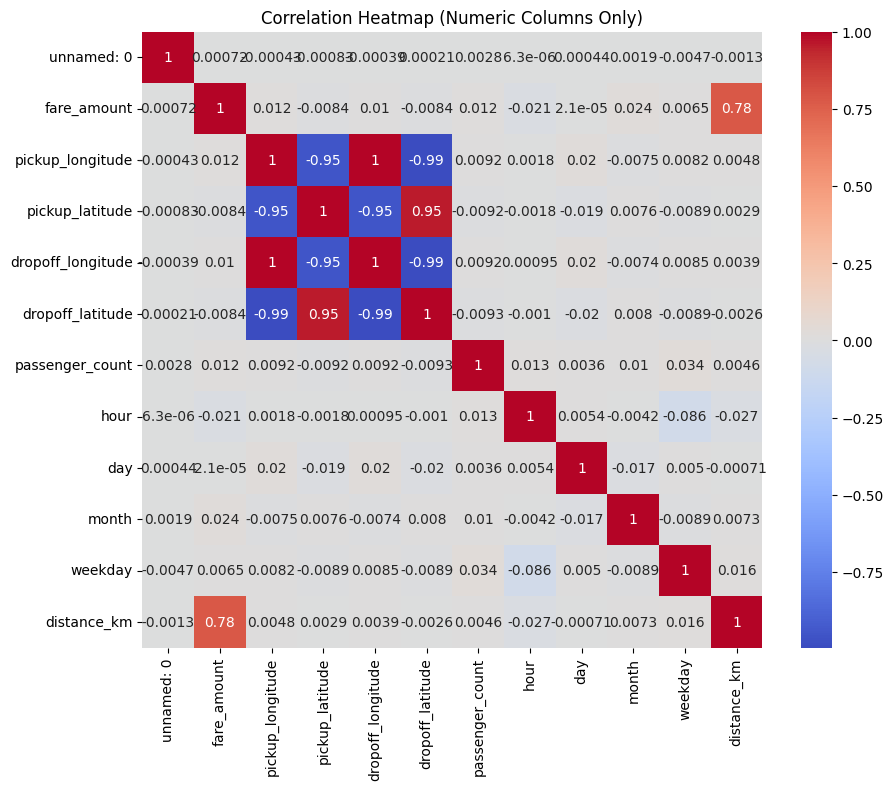

Top correlations with fare_amount:
fare_amount          1.000000
distance_km          0.778756
month                0.024185
passenger_count      0.012081
pickup_longitude     0.011725
dropoff_longitude    0.010253
weekday              0.006491
unnamed: 0           0.000720
day                  0.000021
pickup_latitude     -0.008359
Name: fare_amount, dtype: float64


In [21]:
# 📘 Step 10: Correlation Matrix (Fixed)
# Select only numeric columns to avoid datetime/string conversion errors
numeric_df = df.select_dtypes(include=[np.number])

corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

print("Top correlations with fare_amount:")
print(corr['fare_amount'].sort_values(ascending=False).head(10))


In [23]:
# 📘 Step 11: Select Features
features = ['distance_km', 'hour', 'weekday']
X = df[features]
y = df['fare_amount']

print("Selected Features:", features)
print("Shape of X:", X.shape)


Selected Features: ['distance_km', 'hour', 'weekday']
Shape of X: (193908, 3)


In [25]:
# 📘 Step 12: Split and Scale Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training Data:", X_train.shape)
print("Testing Data:", X_test.shape)


Training Data: (155126, 3)
Testing Data: (38782, 3)


In [27]:
# 📘 Step 13: Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))

print("📈 Linear Regression Results:")
print(f"R2 Score: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")


📈 Linear Regression Results:
R2 Score: 0.6648
RMSE: 5.6403


In [29]:
# 📘 Step 14: Random Forest Regressor Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))

print("🌲 Random Forest Results:")
print(f"R2 Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


🌲 Random Forest Results:
R2 Score: 0.7645
RMSE: 4.7275


In [31]:
# 📘 Step 15: Compare Models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 Score': [r2_lr, r2_rf],
    'RMSE': [rmse_lr, rmse_rf]
})
results


,Model,R2 Score,RMSE
0,Linear Regression,0.664768,5.640304
1,Random Forest,0.764489,4.727544


In [33]:
# 📘 Step 16: Cross Validation (5-fold)
cv_rmse_lr = -cross_val_score(lr, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
cv_rmse_rf = -cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()

print(f"Linear Regression CV RMSE: {cv_rmse_lr:.4f}")
print(f"Random Forest CV RMSE: {cv_rmse_rf:.4f}")


Linear Regression CV RMSE: 6.1048
Random Forest CV RMSE: 4.9977


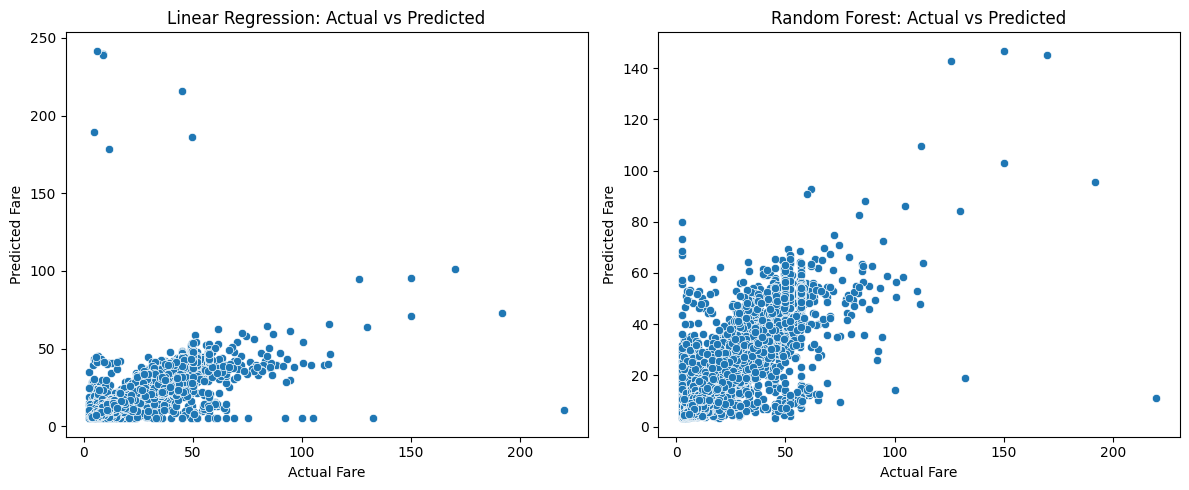

In [35]:
# 📘 Step 17: Visualize Actual vs Predicted Fares
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")

plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.tight_layout()
plt.show()


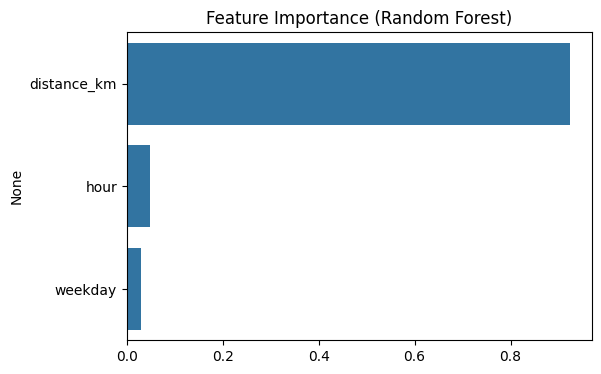

In [37]:
# 📘 Step 18: Feature Importance (Random Forest)
fi = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=fi.values, y=fi.index)
plt.title("Feature Importance (Random Forest)")
plt.show()
